In [25]:
#First, let's load the datasets and take a look at the first few rows of each.
import pandas as pd

# Load the datasets
file_paths = [
    '42_District_wise_crimes_committed_against_women_2001_2012.csv',
    '01_District_wise_crimes_committed_IPC_2001_2012.csv',
    '03_District_wise_crimes_committed_against_children_2001_2012.csv'
]

# Read the data files
crimes_against_women = pd.read_csv(file_paths[0])
ipc_crimes = pd.read_csv(file_paths[1])
crimes_against_children = pd.read_csv(file_paths[2])

# Display the first few rows of each dataset
crimes_against_women_head = crimes_against_women.head()
ipc_crimes_head = ipc_crimes.head()
crimes_against_children_head = crimes_against_children.head()

(crimes_against_women_head, ipc_crimes_head, crimes_against_children_head)


(         STATE/UT       DISTRICT  Year  Rape  Kidnapping and Abduction  \
 0  ANDHRA PRADESH       ADILABAD  2001    50                        30   
 1  ANDHRA PRADESH      ANANTAPUR  2001    23                        30   
 2  ANDHRA PRADESH       CHITTOOR  2001    27                        34   
 3  ANDHRA PRADESH       CUDDAPAH  2001    20                        20   
 4  ANDHRA PRADESH  EAST GODAVARI  2001    23                        26   
 
    Dowry Deaths  Assault on women with intent to outrage her modesty  \
 0            16                                                149     
 1             7                                                118     
 2            14                                                112     
 3            17                                                126     
 4            12                                                109     
 
    Insult to modesty of Women  Cruelty by Husband or his Relatives  \
 0                          34       

We will start with DATA PREPRATION

In [26]:
#Lets start by combining the datasets into a single comprehensive dataset. ​​
# Merge datasets on STATE/UT, DISTRICT, and Year columns
# First, ensure that the column names are consistent for merging
crimes_against_women.rename(columns={'Year': 'YEAR'}, inplace=True)
crimes_against_children.rename(columns={'Year': 'YEAR'}, inplace=True)

# Merge the datasets
merged_data = ipc_crimes.merge(crimes_against_women, on=['STATE/UT', 'DISTRICT', 'YEAR'], how='outer')
merged_data = merged_data.merge(crimes_against_children, on=['STATE/UT', 'DISTRICT', 'YEAR'], how='outer')

# Display the first few rows of the merged dataset
merged_data_head = merged_data.head()
merged_data_head




,STATE/UT,DISTRICT,YEAR,MURDER,ATTEMPT TO MURDER,CULPABLE HOMICIDE NOT AMOUNTING TO MURDER,RAPE,CUSTODIAL RAPE,OTHER RAPE,KIDNAPPING & ABDUCTION,...,Kidnapping and Abduction_y,Foeticide,Abetment of suicide,Exposure and abandonment,Procuration of minor girls,Buying of girls for prostitution,Selling of girls for prostitution,Prohibition of child marriage act,Other Crimes,Total
0,ANDHRA PRADESH,ADILABAD,2001,101.0,60.0,17.0,50.0,0.0,50.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ANDHRA PRADESH,ANANTAPUR,2001,151.0,125.0,1.0,23.0,0.0,23.0,53.0,...,29.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
2,ANDHRA PRADESH,CHITTOOR,2001,101.0,57.0,2.0,27.0,0.0,27.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ANDHRA PRADESH,CUDDAPAH,2001,80.0,53.0,1.0,20.0,0.0,20.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ANDHRA PRADESH,EAST GODAVARI,2001,82.0,67.0,1.0,23.0,0.0,23.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's compute these aggregate statistics and prepare the data for clustering.

1. Aggregate Crime Statistics: Sum all crime-related columns for each district.
2. Normalization: Normalize the data to ensure fair clustering.

In [27]:
# Replace NaN values with 0
merged_data.fillna(0, inplace=True)

# List of crime-related columns to aggregate
crime_columns = merged_data.columns.difference(['STATE/UT', 'DISTRICT', 'YEAR'])

# Create a new column 'Total_Crimes' which is the sum of all crime-related columns
merged_data['Total_Crimes'] = merged_data[crime_columns].sum(axis=1)

# Aggregate the data by STATE/UT and DISTRICT
aggregated_data = merged_data.groupby(['STATE/UT', 'DISTRICT']).agg({'Total_Crimes': 'sum'}).reset_index()

# Normalize the 'Total_Crimes' column for fair clustering
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
aggregated_data['Normalized_Total_Crimes'] = scaler.fit_transform(aggregated_data[['Total_Crimes']])

# Display the first few rows of the aggregated data
aggregated_data.head()


,STATE/UT,DISTRICT,Total_Crimes,Normalized_Total_Crimes
0,A & N ISLANDS,A and N ISLANDS,1815.0,0.000335
1,A & N ISLANDS,ANDAMAN,16707.0,0.003086
2,A & N ISLANDS,CAR,59.0,0.000011
3,A & N ISLANDS,NICOBAR,509.0,0.000094
4,A & N ISLANDS,NORTH,270.0,0.000050


Now proceeding with clustering using the normalized total crimes data.

Clustering with K-means: Create 3 clusters.
Label the clusters: Assign labels to the clusters based on their crime intensity.

In [28]:
from sklearn.cluster import KMeans

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_data['Cluster'] = kmeans.fit_predict(aggregated_data[['Normalized_Total_Crimes']])

# Map the cluster labels to more descriptive names
cluster_map = {0: 'Peaceful Areas', 1: 'Moderate Areas', 2: 'Sensitive Areas'}
aggregated_data['Cluster_Label'] = aggregated_data['Cluster'].map(cluster_map)

# Ensure that the mapping correctly represents the crime intensity
# Reassign cluster labels based on the mean crime rates of each cluster
cluster_means = aggregated_data.groupby('Cluster')['Total_Crimes'].mean().sort_values()
cluster_label_map = {cluster_means.index[0]: 'Peaceful Areas', 
                     cluster_means.index[1]: 'Moderate Areas', 
                     cluster_means.index[2]: 'Sensitive Areas'}
aggregated_data['Cluster_Label'] = aggregated_data['Cluster'].map(cluster_label_map)

# Displaying the data
aggregated_data.head(50)


C:\Users\yadav\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\yadav\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,STATE/UT,DISTRICT,Total_Crimes,Normalized_Total_Crimes,Cluster,Cluster_Label
0,A & N ISLANDS,A and N ISLANDS,1815.0,0.000335,0,Peaceful Areas
1,A & N ISLANDS,ANDAMAN,16707.0,0.003086,0,Peaceful Areas
2,A & N ISLANDS,CAR,59.0,0.000011,0,Peaceful Areas
3,A & N ISLANDS,NICOBAR,509.0,0.000094,0,Peaceful Areas
4,A & N ISLANDS,NORTH,270.0,0.000050,0,Peaceful Areas
5,A & N ISLANDS,SOUTH,1231.0,0.000227,0,Peaceful Areas
6,A & N ISLANDS,TOTAL,20591.0,0.003803,0,Peaceful Areas
7,ANDHRA PRADESH,ADILABAD,138429.0,0.025570,0,Peaceful Areas
8,ANDHRA PRADESH,ANANTAPUR,133129.0,0.024591,0,Peaceful Areas
9,ANDHRA PRADESH,CHITTOOR,171988.0,0.031768,0,Peaceful Areas


Creating DataFrames for Each Cluster

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create DataFrames for each cluster
sensitive_areas_df = aggregated_data[aggregated_data['Cluster_Label'] == 'Sensitive Areas']
moderate_areas_df = aggregated_data[aggregated_data['Cluster_Label'] == 'Moderate Areas']
peaceful_areas_df = aggregated_data[aggregated_data['Cluster_Label'] == 'Peaceful Areas']

# Display first few rows of each DataFrame
sensitive_areas_df.head(15), moderate_areas_df.head(15), peaceful_areas_df.head(15)


(           STATE/UT DISTRICT  Total_Crimes  Normalized_Total_Crimes  Cluster  \
 32   ANDHRA PRADESH    TOTAL     4634812.0                 0.856110        1   
 498  MADHYA PRADESH    TOTAL     5413805.0                 1.000000        1   
 545     MAHARASHTRA    TOTAL     5364150.0                 0.990828        1   
 717       RAJASTHAN    TOTAL     4190368.0                 0.774015        1   
 760      TAMIL NADU    TOTAL     4408885.0                 0.814378        1   
 855   UTTAR PRADESH    TOTAL     4402824.0                 0.813259        1   
 
        Cluster_Label  
 32   Sensitive Areas  
 498  Sensitive Areas  
 545  Sensitive Areas  
 717  Sensitive Areas  
 760  Sensitive Areas  
 855  Sensitive Areas  ,
          STATE/UT        DISTRICT  Total_Crimes  Normalized_Total_Crimes  \
 93          ASSAM           TOTAL     1422018.0                 0.262665   
 138         BIHAR           TOTAL     2996011.0                 0.553402   
 174  CHHATTISGARH           TO

Now through visualtion we will get some observation.

1. Crime Rate Distribution

C:\Users\yadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


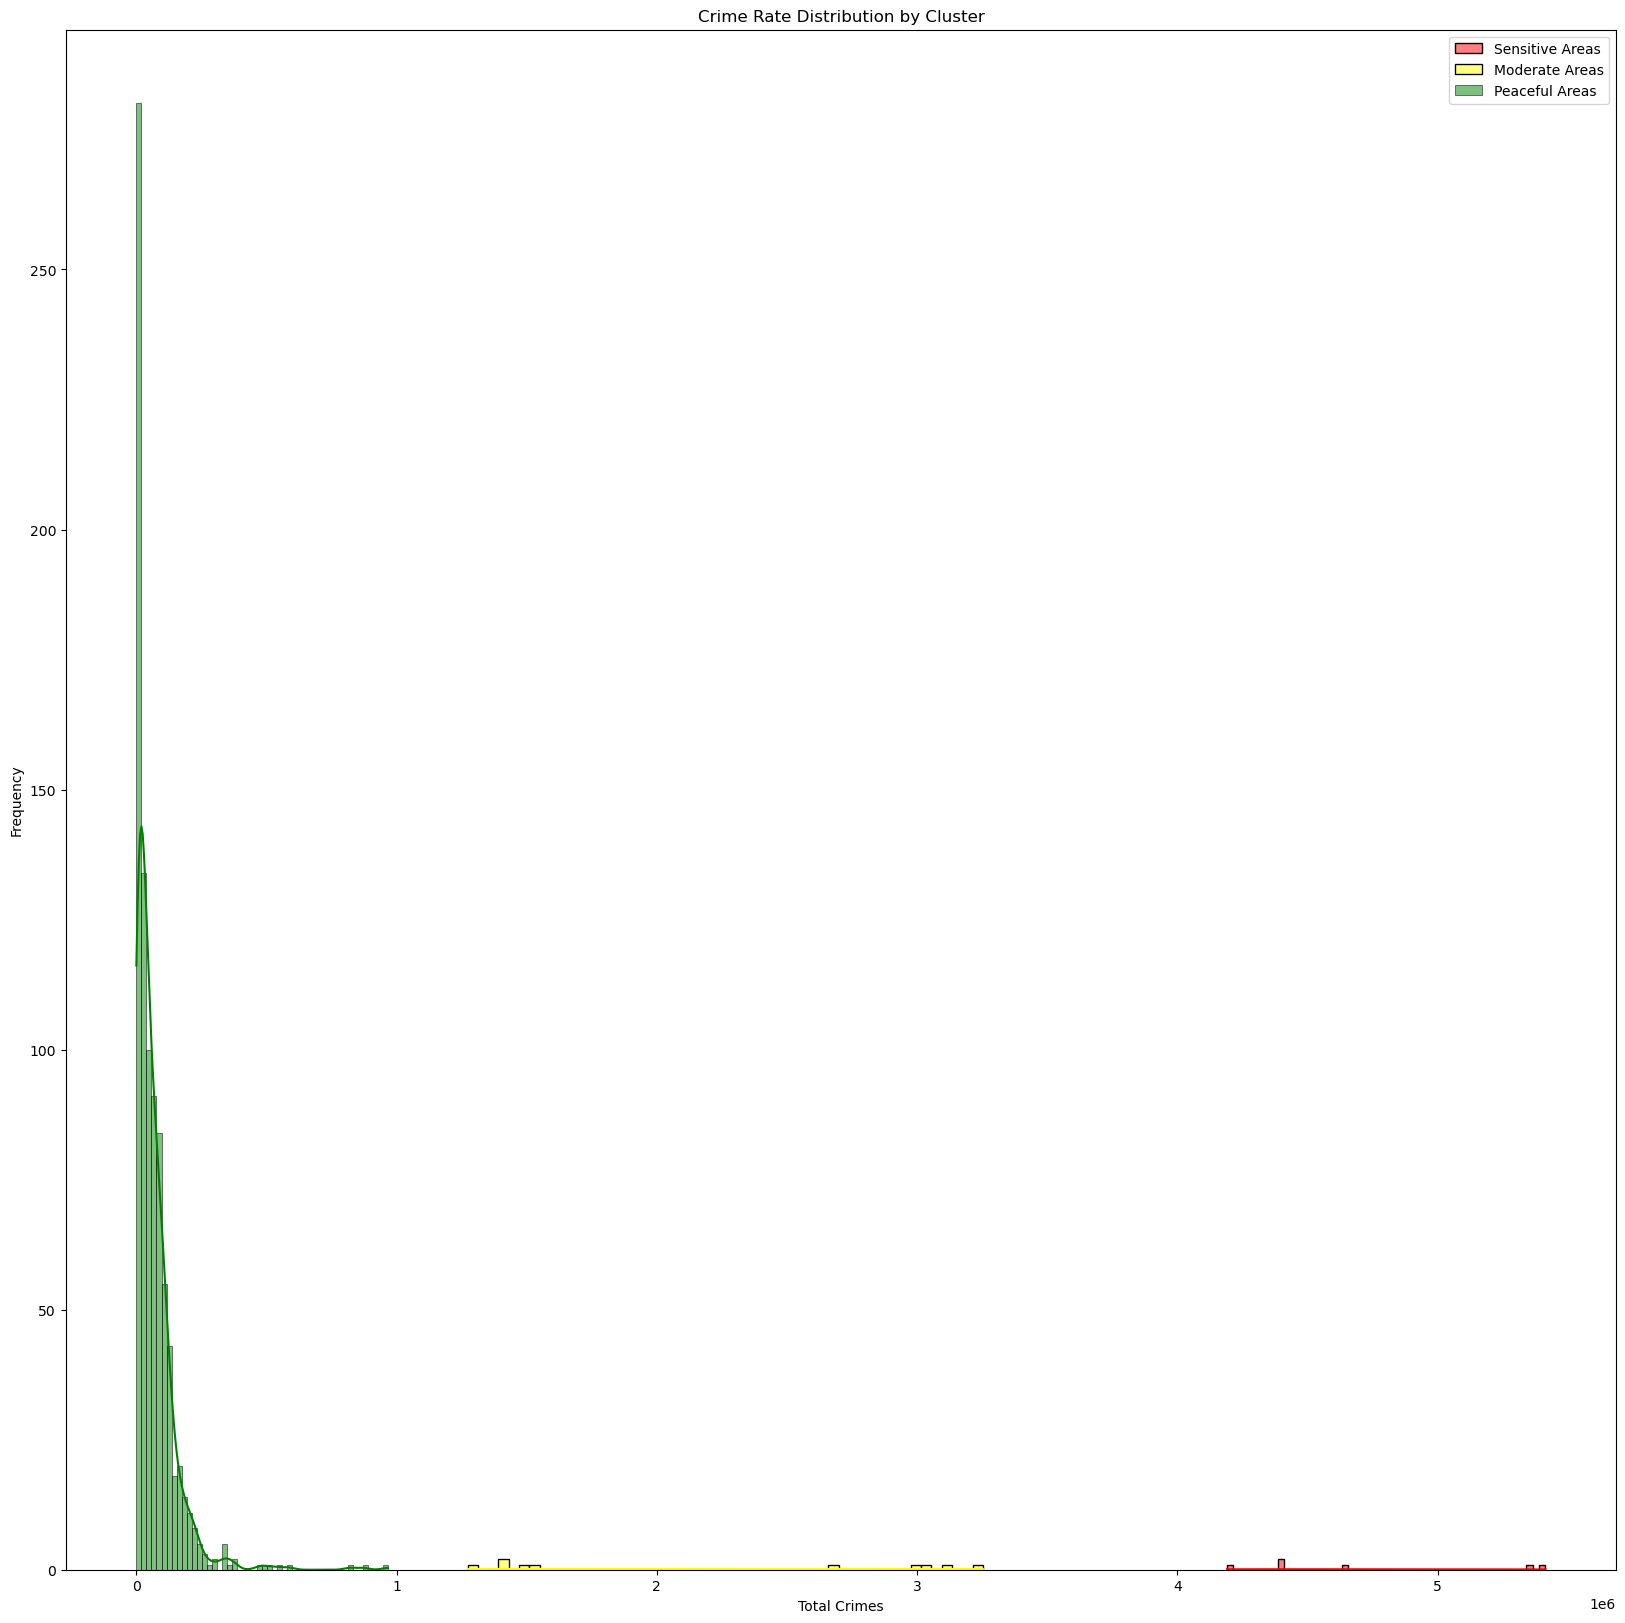

In [30]:
# Histogram of crime rates for each cluster
plt.figure(figsize=(20, 20))

sns.histplot(sensitive_areas_df['Total_Crimes'], kde=True, color='red', label='Sensitive Areas', bins=50)
sns.histplot(moderate_areas_df['Total_Crimes'], kde=True, color='yellow', label='Moderate Areas', bins=50)
sns.histplot(peaceful_areas_df['Total_Crimes'], kde=True, color='green', label='Peaceful Areas', bins=50)

plt.title('Crime Rate Distribution by Cluster')
plt.xlabel('Total Crimes')
plt.ylabel('Frequency')
plt.legend()
plt.show()


From this graph we can observe that, Most of the area is under the Green color, It shows only few places are there in the country which is affected as senstive area or moderate area.

2. Socio-economic Correlation

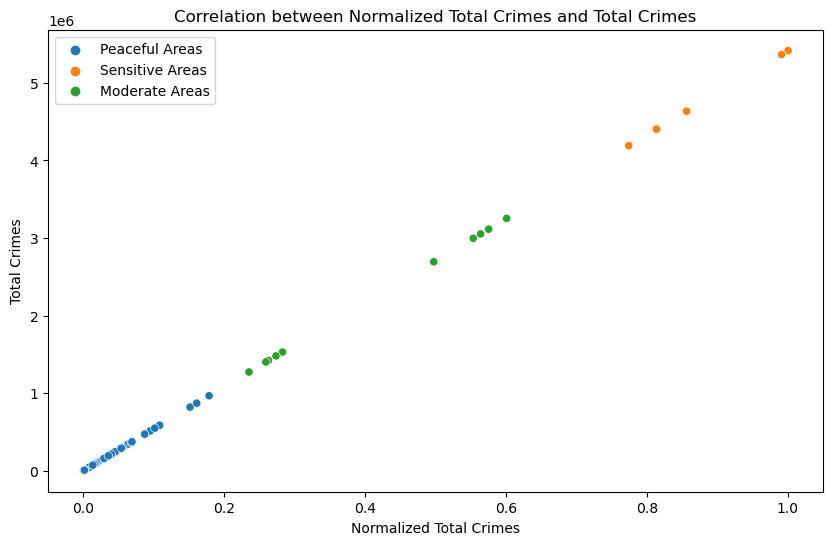

In [32]:
# Scatter plot to examine correlation between normalized total crimes and total crimes
plt.figure(figsize=(10, 6))

sns.scatterplot(data=aggregated_data, x='Normalized_Total_Crimes', y='Total_Crimes', hue='Cluster_Label')

plt.title('Correlation between Normalized Total Crimes and Total Crimes')
plt.xlabel('Normalized Total Crimes')
plt.ylabel('Total Crimes')
plt.legend()
plt.show()



This graph represent the correlation between the the cluster of data i.e Senstive, Moderate and peaceful area.

Distribution of Crime Rates Across All Districts.

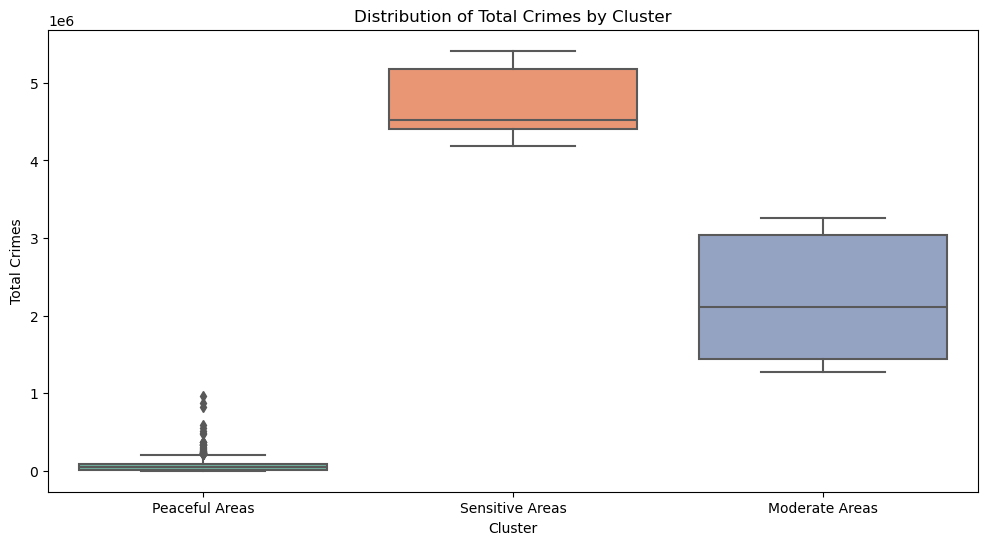

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_Label', y='Total_Crimes', data=aggregated_data, palette='Set2')

plt.title('Distribution of Total Crimes by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Crimes')
plt.show()


Total Crimes by State/UT.

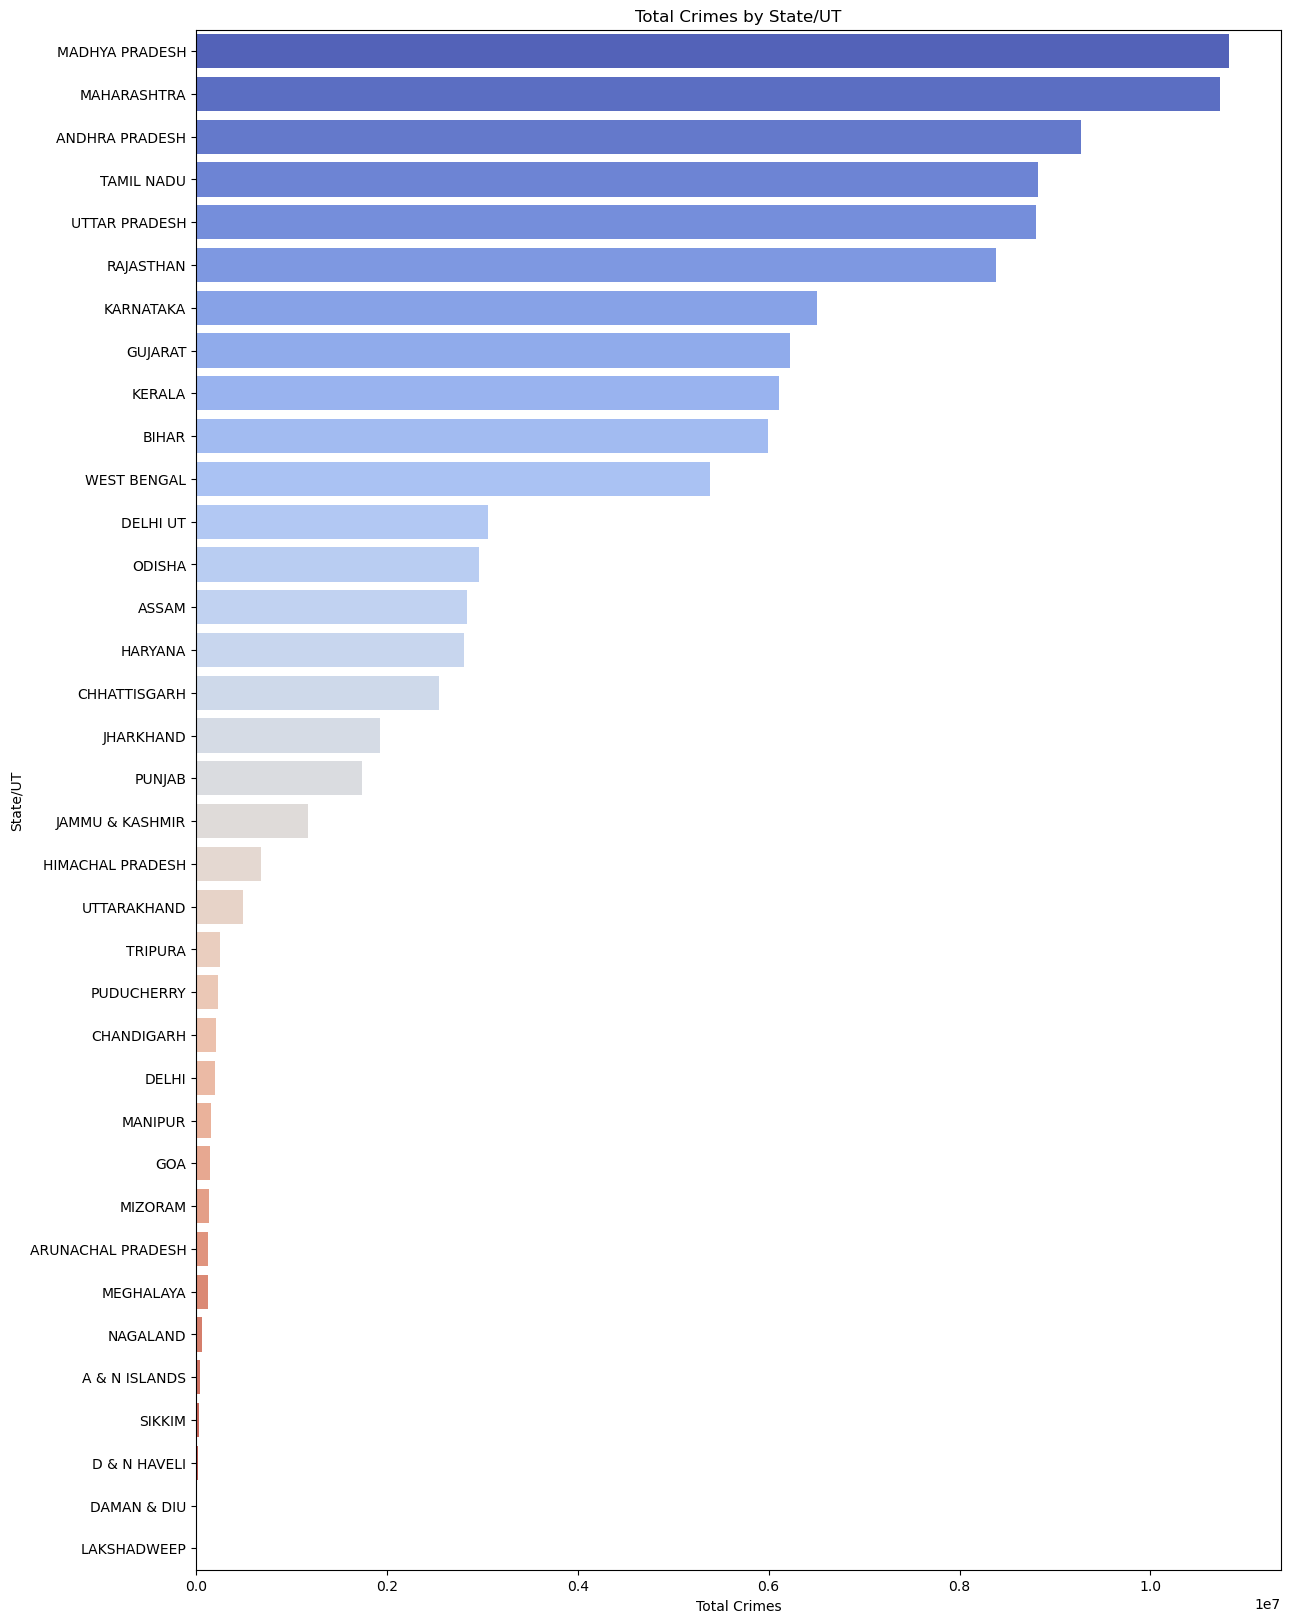

In [41]:
plt.figure(figsize=(14, 20))
sns.barplot(x='Total_Crimes', y='STATE/UT', data=aggregated_data.groupby('STATE/UT').sum().reset_index().sort_values('Total_Crimes', ascending=False), palette='coolwarm')

plt.title('Total Crimes by State/UT')
plt.xlabel('Total Crimes')
plt.ylabel('State/UT')
plt.show()


From this graph we can clearly see that M.P has the most crime records.

Heatmap of Crimes in Different Districts.

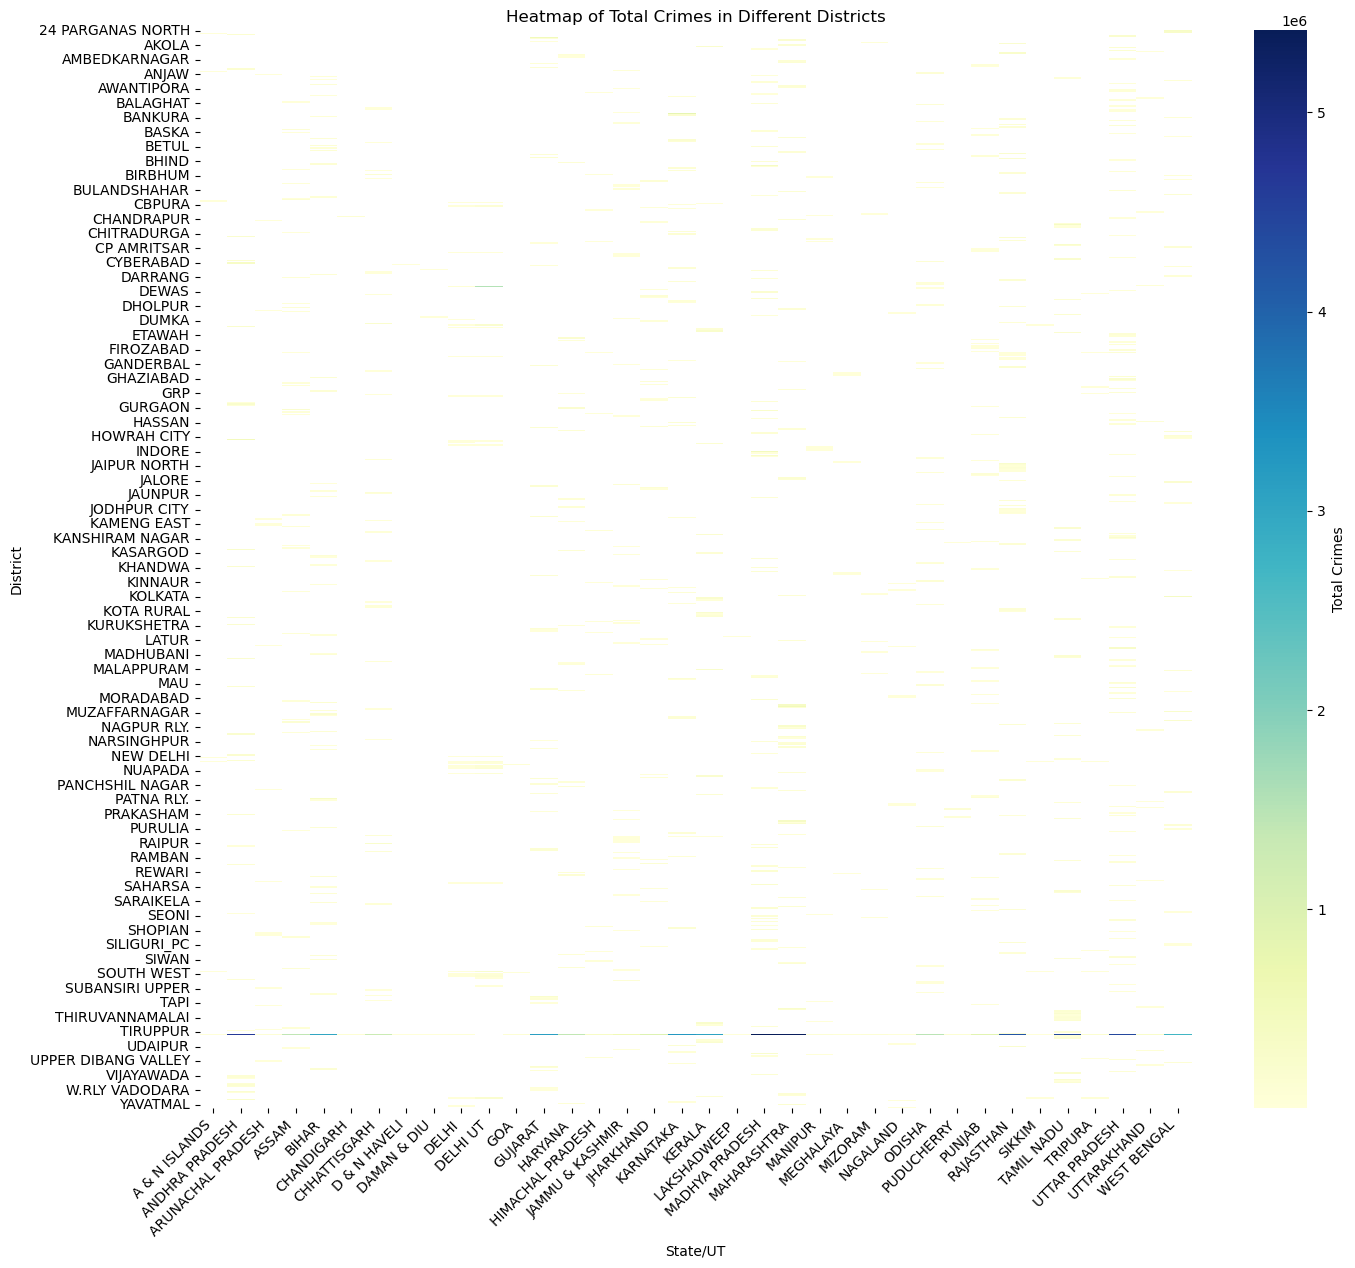

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows with very low or zero crimes
filtered_data = aggregated_data[aggregated_data['Total_Crimes'] > 0]

# Pivot table for heatmap
crime_pivot = filtered_data.pivot_table(index='DISTRICT', columns='STATE/UT', values='Total_Crimes', aggfunc='sum')

# Normalize the data (optional, comment out if not needed)
# crime_pivot = crime_pivot.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Plot the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(crime_pivot, cmap='YlGnBu', annot=False, fmt='.0f', cbar_kws={'label': 'Total Crimes'})

plt.title('Heatmap of Total Crimes in Different Districts')
plt.xlabel('State/UT')
plt.ylabel('District')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


This heatmap is showing that, the intensity of crime in different district, We can see that Intensity of crime is consolidated to only few state and district other than that everything comes under peacefull area.   

Pairplot to Explore Relationships Between Variables

C:\Users\yadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


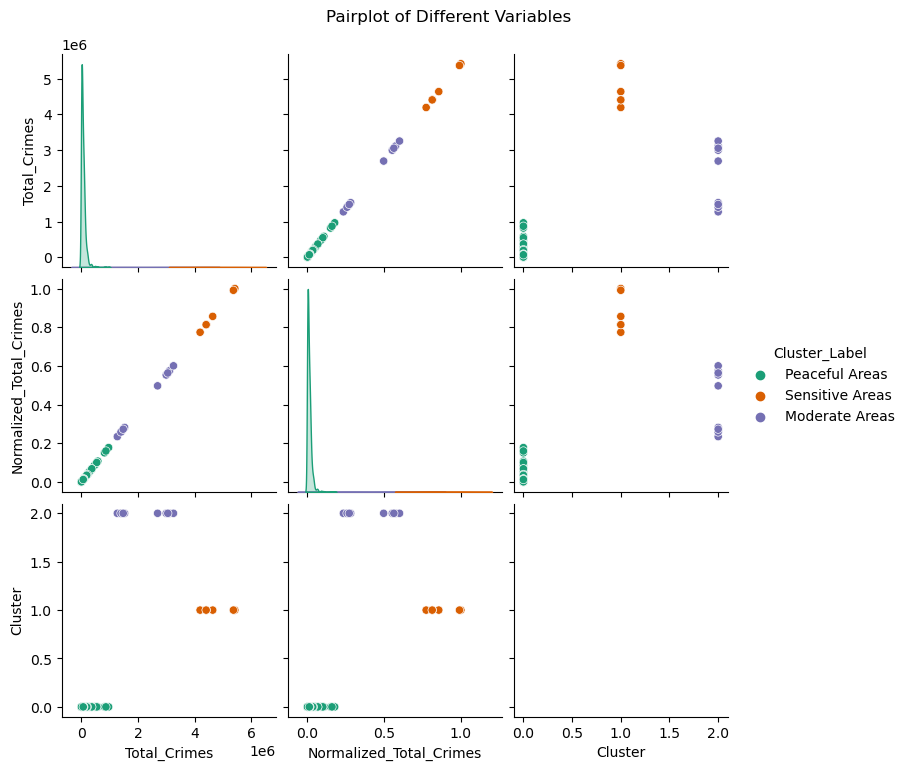

In [45]:
sns.pairplot(aggregated_data, hue='Cluster_Label', palette='Dark2')
plt.suptitle('Pairplot of Different Variables', y=1.02)
plt.show()



Identifying Safest and Most Unsafe Districts.

We will sort the DataFrame based on Total_Crimes to find the top 10 districts with the lowest and highest crime rates.

In [46]:
# Identify the top 10 safest districts (lowest total crimes)
safest_districts = aggregated_data.nsmallest(10, 'Total_Crimes')

# Identify the top 10 most unsafe districts (highest total crimes)
most_unsafe_districts = aggregated_data.nlargest(10, 'Total_Crimes')

# Display the identified districts
print("Safest Districts")
print(safest_districts[['STATE/UT', 'DISTRICT', 'Total_Crimes']])

print("\nMost Unsafe Districts")
print(most_unsafe_districts[['STATE/UT', 'DISTRICT', 'Total_Crimes']])


Safest Districts
            STATE/UT         DISTRICT  Total_Crimes
85             ASSAM       N.C. HILLS           0.0
204            DELHI         SPL CELL           0.0
205            DELHI              STF           0.0
282          HARYANA            HISAR           0.0
344  JAMMU & KASHMIR      RAILWAYSJMU           0.0
562        MEGHALAYA  GARI HILLS EAST           0.0
735       TAMIL NADU     KANCHEEPURAM           0.0
190            DELHI    I.G.I.AIRPORT           2.0
199            DELHI           S.T.F.           2.0
186            DELHI              EOW           4.0

Most Unsafe Districts
           STATE/UT DISTRICT  Total_Crimes
498  MADHYA PRADESH    TOTAL     5413805.0
545     MAHARASHTRA    TOTAL     5364150.0
32   ANDHRA PRADESH    TOTAL     4634812.0
760      TAMIL NADU    TOTAL     4408885.0
855   UTTAR PRADESH    TOTAL     4402824.0
717       RAJASTHAN    TOTAL     4190368.0
413       KARNATAKA    TOTAL     3252393.0
267         GUJARAT    TOTAL     3114065.0
4

Visualizing the Safest and Most Unsafe Districts.

Bar Plot for Safest Districts

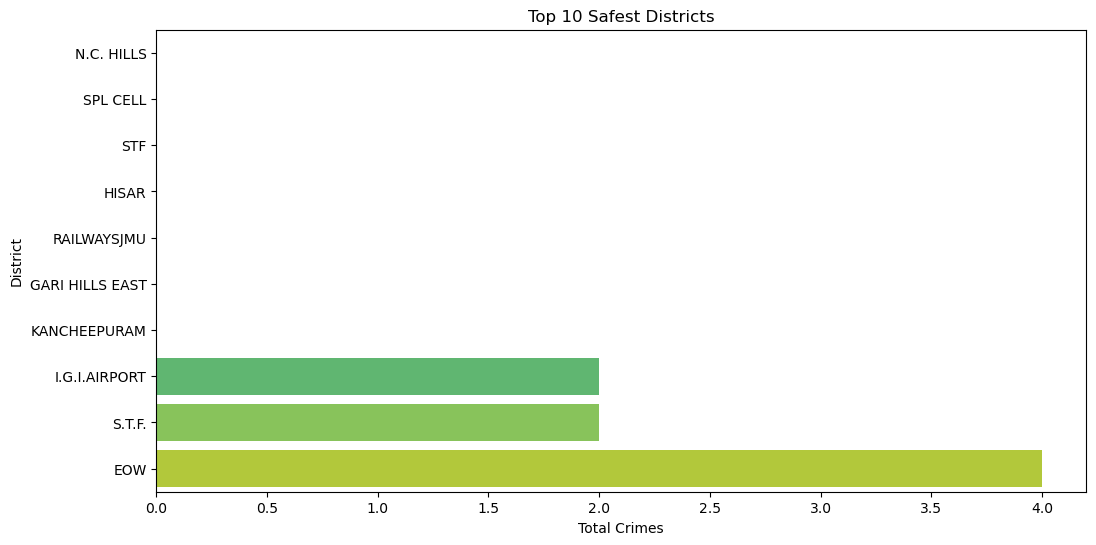

In [34]:
import matplotlib.pyplot as plt

# Bar plot for safest districts
plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Crimes', y='DISTRICT', data=safest_districts, palette='viridis')

plt.title('Top 10 Safest Districts')
plt.xlabel('Total Crimes')
plt.ylabel('District')
plt.show()


2. Bar Plot for Most Unsafe Districts

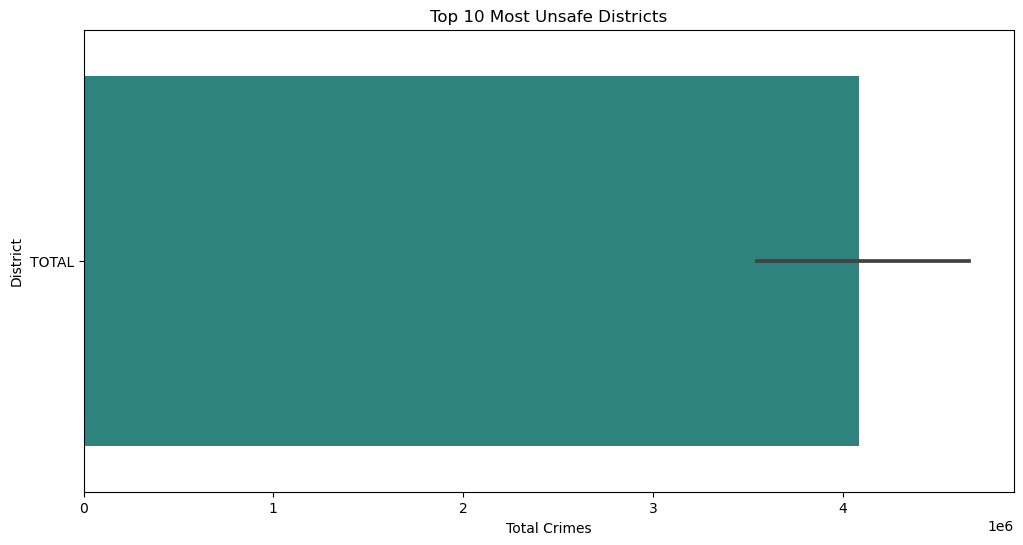

In [36]:
# Bar plot for most unsafe districts
plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Crimes', y='DISTRICT', data=most_unsafe_districts, palette='viridis')

plt.title('Top 10 Most Unsafe Districts')
plt.xlabel('Total Crimes')
plt.ylabel('District')
plt.show()


From this data we can see that few states has total district under senstive area as the intensity of crime in these states are significatly high, like M.P., Maharashtra, U.P, T.N etc are the worst affected states for our country and the most unsafest place to live and on the other hand districts like  N.C. HILLS of Assam, Hisar of Haryana and TAMIL NADU's KANCHEEPURAM etc are the safest place to live.

Analysis of Sensitive Area

1.Factors Impacting More Crimes:

 Population density,
 Socio-economic factors,
 Urbanization level,
 Law enforcement efficiency.


2.Measures to Reduce Crime:

Strengthen law enforcement presence,
Improve socio-economic conditions,
Increase community engagement,
Implement crime prevention programs.